In [9]:
import pandas as pd
import numpy as np
# # set up dictionaries of parameter options for each learner
param_opts = {
    'DecisionTreeClassifier': {},
    'GradientBoostingClassifier': {},
    'KNeighborsClassifier': {},
    'LogisticRegression': {},
    'RandomForestClassifier': {},
    'SVC': {}
}
ml_p = pd.read_csv('ml_p_options.csv')
ml_p.rename(columns={'alg_name':'classifier'},inplace=True)
for ml, df_ml in ml_p.groupby('classifier'):
    for p, df_ml_p in df_ml.groupby('parameters'):
        d = eval(p)
        for keys,v in d.items():
            if keys not in param_opts[ml].keys():
                param_opts[ml][keys] = [v]
            elif v not in param_opts[ml][keys]:
                param_opts[ml][keys].append(v)
print(param_opts)

{'DecisionTreeClassifier': {'criterion': ['entropy', 'gini'], 'max_depth': [2, 4, 6, 8], 'min_samples_leaf': [10, 20, 5], 'min_samples_split': [10, 20, 5]}, 'GradientBoostingClassifier': {'learning_rate': [0.01, 0.1, 1], 'max_depth': [1, 10, 5], 'max_features': ['log2', 'sqrt'], 'min_samples_leaf': [10, 20, 5], 'min_samples_split': [10, 20, 5], 'n_estimators': [100, 250], 'subsample': [0.5, 1]}, 'KNeighborsClassifier': {'n_neighbors': [1, 11, 3, 5, 7, 9], 'p': [1, 2], 'weights': ['distance', 'uniform']}, 'LogisticRegression': {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10, 25], 'dual': ['false', 'true'], 'penalty': ['l1', 'l2']}, 'RandomForestClassifier': {'bootstrap': ['false', 'true'], 'criterion': ['entropy', 'gini'], 'max_features': ['log2', 'sqrt'], 'min_samples_leaf': [10, 20, 5], 'min_samples_split': [10, 20, 5], 'n_estimators': [100, 250]}, 'SVC': {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10, 25], 'kernel': ['poly', 'rbf'], 'tol': [0.0001, 0.001, 0.01, 0.1, 1e-05]}}


In [10]:
import pandas as pd
import numpy as np

data = pd.read_csv('hibachi_combined_results_correct_datasets.csv.gz') 
print(data.head())
data['accuracy'] = data['accuracy'].apply(lambda x: round(x, 3))
print('loaded ',data['dataset'].unique().shape[0],'datasets and ', data['classifier'].unique().shape[0],'classifiers')
# subset data to classifiers used in PennAI
# pennai_classifiers = ['LogisticRegression', 'RandomForestClassifier', 'SVC', 
#                       'KNeighborsClassifier', 'DecisionTreeClassifier', 'GradientBoostingClassifier']
# mask = np.array([c in pennai_classifiers for c in data['classifier'].values])
# data = data.loc[mask,:]
print('datasets (',len(data['dataset'].unique()),')')
print('classifiers (',len(data['classifier'].unique()),'):',data['classifier'].unique())
for ml, df_g in data.groupby('classifier'):
    print('parameters for ',ml,'(',len(df_g['parameters'].unique()),'):',df_g['parameters'].unique()[:5])


                                       dataset              classifier  \
0  AAA_bench_mod_4_up_down_dt_gb_score_0-36112  DecisionTreeClassifier   
1  AAA_bench_mod_4_up_down_dt_gb_score_0-36112  DecisionTreeClassifier   
2  AAA_bench_mod_4_up_down_dt_gb_score_0-36112  DecisionTreeClassifier   
3  AAA_bench_mod_4_up_down_dt_gb_score_0-36112  DecisionTreeClassifier   
4  AAA_bench_mod_4_up_down_dt_gb_score_0-36112  DecisionTreeClassifier   

                                          parameters  accuracy   macrof1  \
0  min_impurity_decrease=0.0,max_features=0.1,cri...     0.549  0.548899   
1  min_impurity_decrease=0.0,max_features=0.1,cri...     0.554  0.554000   
2  min_impurity_decrease=0.0,max_features=0.25,cr...     0.567  0.566989   
3  min_impurity_decrease=0.0,max_features=0.25,cr...     0.556  0.555956   
4  min_impurity_decrease=0.0,max_features=0.5,cri...     0.751  0.750868   

   bal_accuracy  
0         0.549  
1         0.554  
2         0.567  
3         0.556  
4       

In [11]:
from collections import OrderedDict

def convert_params(params):
    """convert from sklearn-style parameter formatting to dictionary, PennAI style."""
    pdict = {}
    for kv in params.split(','):
        if len(kv)==0: continue
        if 'random_state' in kv: continue
#         print(kv.split('='))
        pdict[str(kv.split('=')[0])] = kv.split('=')[1]
    for k,v in pdict.items():
        try:
            pdict[k] = int(v)
        except ValueError:
            try:     
                pdict[k] = float(v)
            except ValueError:
                pass

    return OrderedDict(sorted(pdict.items()))


data['parameters'] = data['parameters'].apply(lambda x: convert_params(x))

In [12]:
for ml, df_g in data.groupby('classifier'):
    print('example parameters for ',ml,'(',len(df_g['parameters'].apply(str).unique()),'):',
           df_g['parameters'].apply(str).unique()[0])

example parameters for  DecisionTreeClassifier ( 280 ): OrderedDict([('criterion', 'gini'), ('max_features', 0.1), ('min_impurity_decrease', 0.0)])
example parameters for  GradientBoostingClassifier ( 450 ): OrderedDict([('learning_rate', 0.01), ('loss', 'deviance'), ('max_features', 'sqrt'), ('min_impurity_decrease', 0.0), ('n_estimators', 10)])
example parameters for  LogisticRegression ( 240 ): OrderedDict([('C', 0.5), ('dual', 'False'), ('fit_intercept', 'True'), ('penalty', 'l1')])
example parameters for  RandomForestClassifier ( 90 ): OrderedDict([('criterion', 'gini'), ('max_features', 'sqrt'), ('min_impurity_decrease', 0.0), ('n_estimators', 10)])
example parameters for  SVC ( 1188 ): OrderedDict([('C', 0.01), ('coef0', 0.0), ('degree', 2), ('gamma', 0.01), ('kernel', 'poly')])


In [17]:
def valid_param_combo(ml,params):
#     print('ml',ml,type(ml).__name__)
#     print('params',params,type(params).__name__)
#     params = eval(params)
    for k,v in params.items():
        if k in param_opts[ml].keys():
            if type(param_opts[ml][k][0]) is int:
                try:
                    if int(v) not in param_opts[ml][k]:
                        return False
                except: 
                    return False
            elif type(param_opts[ml][k][0]) is float:
                try:
                    if float(v) not in param_opts[ml][k]:
                        return False
                except: 
                    return False
            elif v not in param_opts[ml][k]:
                return False
    return True

mask = [valid_param_combo(row['classifier'],row['parameters']) for _, row in data.iterrows()]
mask = mask | (data.classifier=='LogisticRegression')
data_filtered = data.loc[mask]

# data_filtered = data.loc[lambda x: valid_param_combo(i['classifier'],i['parameters']) for i in x]


In [18]:
for ml, df_g in data_filtered.groupby('classifier'):
    print('example parameters for ',ml,'(',len(df_g['parameters'].apply(str).unique()),'):',
           df_g['parameters'].apply(str).unique()[0])

example parameters for  DecisionTreeClassifier ( 280 ): OrderedDict([('criterion', 'gini'), ('max_features', 0.1), ('min_impurity_decrease', 0.0)])
example parameters for  GradientBoostingClassifier ( 60 ): OrderedDict([('learning_rate', 0.01), ('loss', 'deviance'), ('max_features', 'sqrt'), ('min_impurity_decrease', 0.0), ('n_estimators', 100)])
example parameters for  LogisticRegression ( 240 ): OrderedDict([('C', 0.5), ('dual', 'False'), ('fit_intercept', 'True'), ('penalty', 'l1')])
example parameters for  RandomForestClassifier ( 20 ): OrderedDict([('criterion', 'gini'), ('max_features', 'sqrt'), ('min_impurity_decrease', 0.0), ('n_estimators', 100)])
example parameters for  SVC ( 600 ): OrderedDict([('C', 0.01), ('coef0', 0.0), ('degree', 2), ('gamma', 0.01), ('kernel', 'poly')])


In [19]:
param_opts['LogisticRegression']

{'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10, 25],
 'dual': ['false', 'true'],
 'penalty': ['l1', 'l2']}

In [21]:
data_filtered.head()

,dataset,classifier,parameters,accuracy,macrof1,bal_accuracy
0,AAA_bench_mod_4_up_down_dt_gb_score_0-36112,DecisionTreeClassifier,"{'criterion': 'gini', 'max_features': 0.1, 'mi...",0.549,0.548899,0.549
1,AAA_bench_mod_4_up_down_dt_gb_score_0-36112,DecisionTreeClassifier,"{'criterion': 'entropy', 'max_features': 0.1, ...",0.554,0.554000,0.554
2,AAA_bench_mod_4_up_down_dt_gb_score_0-36112,DecisionTreeClassifier,"{'criterion': 'gini', 'max_features': 0.25, 'm...",0.567,0.566989,0.567
3,AAA_bench_mod_4_up_down_dt_gb_score_0-36112,DecisionTreeClassifier,"{'criterion': 'entropy', 'max_features': 0.25,...",0.556,0.555956,0.556
4,AAA_bench_mod_4_up_down_dt_gb_score_0-36112,DecisionTreeClassifier,"{'criterion': 'gini', 'max_features': 0.5, 'mi...",0.751,0.750868,0.751


In [22]:
print('data_filtered shape: ', data_filtered.shape)
print('datasets (',len(data_filtered['dataset'].unique()),')')
print('classifiers (',len(data_filtered['classifier'].unique()),'):',data_filtered['classifier'].unique())
for ml, df_g in data_filtered.groupby('classifier'):
    print('parameters for ',ml,'(',len(df_g['parameters'].apply(str).unique()),'):',
           df_g['parameters'].apply(str).unique()[:5])

data_filtered shape:  (105640, 6)
datasets ( 131 )
classifiers ( 5 ): ['DecisionTreeClassifier' 'GradientBoostingClassifier'
 'LogisticRegression' 'RandomForestClassifier' 'SVC']
parameters for  DecisionTreeClassifier ( 280 ): ["OrderedDict([('criterion', 'gini'), ('max_features', 0.1), ('min_impurity_decrease', 0.0)])"
 "OrderedDict([('criterion', 'entropy'), ('max_features', 0.1), ('min_impurity_decrease', 0.0)])"
 "OrderedDict([('criterion', 'gini'), ('max_features', 0.25), ('min_impurity_decrease', 0.0)])"
 "OrderedDict([('criterion', 'entropy'), ('max_features', 0.25), ('min_impurity_decrease', 0.0)])"
 "OrderedDict([('criterion', 'gini'), ('max_features', 0.5), ('min_impurity_decrease', 0.0)])"]
parameters for  GradientBoostingClassifier ( 60 ): ["OrderedDict([('learning_rate', 0.01), ('loss', 'deviance'), ('max_features', 'sqrt'), ('min_impurity_decrease', 0.0), ('n_estimators', 100)])"
 "OrderedDict([('learning_rate', 0.01), ('loss', 'exponential'), ('max_features', 'sqrt'), ('

# remove any algorithms that don't have results for all datasets

In [26]:
clean_data = data_filtered
print('original size:',len(clean_data))
clean_data.loc[:, 'algorithm-parameters'] = (                                             
                                       clean_data['classifier'].values + '|' +                     
                                       clean_data['parameters'].apply(str).values) 
all_datasets = np.unique(clean_data['dataset'].values)
algp_toremove = []
for algp, group in clean_data.groupby('algorithm-parameters'):
    if (group['dataset'].count()<len(all_datasets)):
        #print(algp, '\n\t is missing results for', [d for d in all_datasets if d not in np.unique(group['dataset'])])
        #print('removing',algp)
        algp_toremove.append(algp)
        
mask = np.array([ap not in algp_toremove for ap in clean_data['algorithm-parameters'].values])
print('removing',np.sum(~mask),'algorithm-parameter combinations')
clean_data = clean_data.loc[mask,:]
print('new size:',len(clean_data))
clean_data.drop('algorithm-parameters',axis=1,inplace=True)

clean_data.groupby('classifier').count()

original size: 105640


/home/bill/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


removing 13940 algorithm-parameter combinations
new size: 91700


/home/bill/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,dataset,parameters,accuracy,macrof1,bal_accuracy
classifier,,,,,
DecisionTreeClassifier,36680,36680,36680,36680,36680
GradientBoostingClassifier,7860,7860,7860,7860,7860
LogisticRegression,31440,31440,31440,31440,31440
RandomForestClassifier,2620,2620,2620,2620,2620
SVC,13100,13100,13100,13100,13100


In [27]:
for ml, df_g in clean_data.groupby('classifier'):
    print('example parameters for ',ml,'(',len(df_g['parameters'].apply(str).unique()),'):',
           df_g['parameters'].apply(str).unique()[0])

example parameters for  DecisionTreeClassifier ( 280 ): OrderedDict([('criterion', 'gini'), ('max_features', 0.1), ('min_impurity_decrease', 0.0)])
example parameters for  GradientBoostingClassifier ( 60 ): OrderedDict([('learning_rate', 0.01), ('loss', 'deviance'), ('max_features', 'sqrt'), ('min_impurity_decrease', 0.0), ('n_estimators', 100)])
example parameters for  LogisticRegression ( 240 ): OrderedDict([('C', 0.5), ('dual', 'False'), ('fit_intercept', 'True'), ('penalty', 'l1')])
example parameters for  RandomForestClassifier ( 20 ): OrderedDict([('criterion', 'gini'), ('max_features', 'sqrt'), ('min_impurity_decrease', 0.0), ('n_estimators', 100)])
example parameters for  SVC ( 100 ): OrderedDict([('C', 0.01), ('coef0', 0.0), ('degree', 2), ('gamma', 0.01), ('kernel', 'poly')])


# calculate ranks

In [28]:
clean_data['norm_score'] = clean_data.groupby('dataset')['bal_accuracy'].transform(
                                                                lambda x: (x - x.min()) / (x.max() - x.min()))
clean_data['round_norm_score'] = clean_data['norm_score'].apply(lambda x: round(x,3))

clean_data['ranking'] = clean_data.groupby('dataset')['round_norm_score'].rank(ascending=False,method='dense')

/home/bill/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/bill/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bill/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

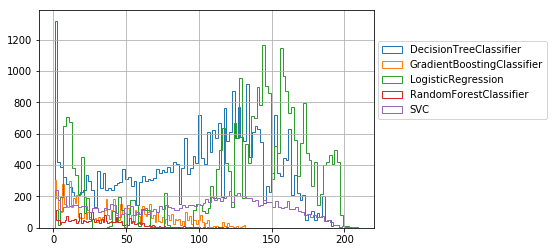

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure()
for clf, df in clean_data.groupby('algorithm'):
    df['ranking'].hist(bins=int(len(clean_data['ranking'].unique())/2),histtype='step',label=clf,ax=plt.gca())
#     plt.title(clf)
plt.legend(loc=[1.01,0.5])

# write modified data to file

In [34]:
print(clean_data.columns)
clean_data.rename(columns={'classifier':'algorithm'},inplace=True)
clean_data.to_csv('hibachi_combined_results_correct_datasets_mock_experiment.tsv.gz',compression='gzip',
            index=False,
            sep='\t')

Index(['dataset', 'algorithm', 'parameters', 'accuracy', 'macrof1',
       'bal_accuracy', 'norm_score', 'round_norm_score', 'ranking'],
      dtype='object')


/home/bill/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
